Experimented originally with creating image match
https://github.com/MarcoForte/closed-form-matting/blob/master/closed_form_matting.py
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.134.8491&rep=rep1&type=pdf

In [1]:
import sys
sys.path.append('/Users/rsingh/Oyla/Work/our_python_dev/')
sys.path.append('/Users/rsingh/Packages/closed-form-matting//')

In [2]:
import closed_form_matting
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.io

In [3]:
def hist_match(original, specified):

    oldshape = original.shape
    original = original.ravel()
    specified = specified.ravel()

    # get the set of unique pixel values and their corresponding indices and counts
    s_values, bin_idx, s_counts = np.unique(original, return_inverse=True,return_counts=True)
    t_values, t_counts = np.unique(specified, return_counts=True)

    # Calculate s_k for original image
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    
    # Calculate s_k for specified image
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # Round the values
    sour = np.around(s_quantiles*255)
    temp = np.around(t_quantiles*255)
    
    # Map the rounded values
    b=[]
    for data in sour[:]:
        b.append(find_nearest_above(temp,data))
    b= np.array(b,dtype='uint8')

    return b[bin_idx].reshape(oldshape)

In [4]:
def find_nearest_above(my_array, target):
    diff = my_array - target
    mask = np.ma.less_equal(diff, -1)
    # We need to mask the negative differences
    # since we are looking for values above
    if np.all(mask):
        c = np.abs(diff).argmin()
        return c # returns min index of the nearest if target is greater than any value
    masked_diff = np.ma.masked_array(diff, mask)
    return masked_diff.argmin()

import cv2
import numpy as np

# Load the images in greyscale
original = cv2.imread('/Users/rsingh/Downloads/graylevel_ppm/temple.ppm',0)
specified = cv2.imread('/Users/rsingh/Downloads/graylevel_ppm/rock.ppm',0)

# perform Histogram Matching
a = hist_match(original, specified)
out =np.array(a,dtype='uint8')
# Display the image
plt.imshow(out)


plt.imshow(original)

plt.imshow(specified)

plt.hist(out.reshape(-1))

In [5]:
from oyla.mvc.utils import *
from solve_foreground_background import solve_foreground_background

In [6]:
from skimage.util import view_as_windows

In [7]:

from solve_foreground_background import solve_foreground_background

In [8]:
def rgb_to_srgb(rgb):
    ret = np.zeros_like(rgb)
    idx0 = rgb <= 0.0031308
    idx1 = rgb > 0.0031308
    ret[idx0] = rgb[idx0] * 12.92
    ret[idx1] = np.power(1.055 * rgb[idx1], 1.0 / 2.4) - 0.055
    return ret

In [9]:
def rgbEqualizeHistogram(rgb,color_ratio=False):
    rgb = (rgb*255).astype('uint8')
    hsv = cv2.cvtColor(rgb,cv2.COLOR_RGB2HSV)
    h,s,v = cv2.split(hsv)
    _v = cv2.equalizeHist(v)
    old_new = _v/(v+0.000001)
    #print(h.dtype)
    if color_ratio:
        h = h.astype('float32')/255.0*old_new
        s = s.astype('float32')/255.0*old_new 
        h = (h*255).astype('uint8')
        s = (s*255).astype('uint8')
    #print(h.dtype)
    hsv = cv2.merge((h,s,_v))
        
    ergb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    
    ergb[ergb>255] = 255
    ergb[ergb<0] = 0
    ergb = ergb.astype('float32')/255.0
    
    return ergb

In [10]:
def Stransform2(x,delta1=0,delta2=1,n=2,m=0.5):
    y = np.zeros_like(x)
    
    ind = np.where((x<=m)&(x>=delta1))
    y[ind] = delta1+(m[ind]-delta1)*np.power((x[ind]-delta1)/(m[ind]-delta1+0.00001),n)
    ind = np.where((x>m)&(x<=delta2))
    y[ind] = delta2-(delta2-m[ind])*np.power((delta2-x[ind])/(delta2-m[ind]+0.00001),n)
    print(np.where(y>1))
    y[y>1] = 1
    y[y<0] = 0
    return y

In [11]:
dir_path='/Users/rsingh/Oyla Dropbox/Oyla/02 Technical/10 Data/Oct 16 - RG visit Set 3/19_data_October_16_19_41_31/////'

In [12]:
input_data_folder_name =  dir_path
csv_file = input_data_folder_name+'/parameters.csv'
parameters = read_csv_parameters(csv_file)

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [13]:
#parameters['adaptive_cmd']['setMinAmplitude'][0] = 100

In [14]:
ambiguity_distance, range_max, range_min, saturation_flag, adc_flag, mod_freq, ampl_min,reflectivity_thresh = some_common_utility(parameters,0)

In [15]:
filter_params = {}
filter_parameters = {}
filter_parameters['filter_cmd'] = {}
filter_parameters = read_csv_parameters("/Users/rsingh/Oyla/Work/our_python_dev/oyla/mvc/filter_params.csv")
for k in filter_parameters['filter_cmd'].keys():
        #print(parameters['filter_cmd'][k][self.epoch_number])
        try:
                filter_params[k] = int(filter_parameters['filter_cmd'][k][0])
                #parameters['filter_cmd'][k][0] = filter_parameters['filter_cmd'][k][0]
        except ValueError:
                pass
filter_params = {}

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [16]:
filter_params['median_filter'] = 1
filter_params['edge_detection'] = 1
filter_params['edge_detection_thresholds'] = 50

In [17]:
index = np.random.randint(0,500)
index = 115
print(index)
rgb = scipy.io.loadmat(dir_path+'/data_c_'+str(index)+'.mat')

rgb = rgb['data'][0][4]

rgb = rgb_depth_view_matching(rgb)

dist = np.fromfile(dir_path+'/imageDistance_c_'+str(index)+'.bin',np.uint16())
ampl = np.fromfile(dir_path+'/imageDistance_c_'+str(index)+'_ampl.bin',np.uint16())

#dist = dist.reshape(120,320)
#ampl = ampl.reshape(120,320)

raw_phase = dist.reshape(120,320)
raw_ampl = ampl.reshape(120,320)
filtered_phase, thresholded_ampl, indices = threshold_filter(raw_phase = raw_phase, raw_ampl = raw_ampl, reflectivity_thresh= reflectivity_thresh,
                                                                             range_max = range_max, range_min = range_min, ampl_min = ampl_min,
                                                                             filter_params = filter_params, ambiguity_distance = ambiguity_distance)

115
Doing median filtering
Doing edge detection


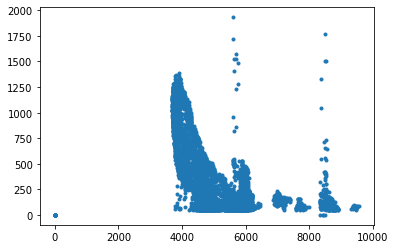

In [18]:
plt.plot(filtered_phase[raw_ampl<65000],thresholded_ampl[raw_ampl<65000],'.')

In [19]:
ampl_min

50.0

In [20]:
_thresholded_ampl = thresholded_ampl.astype('float32')/np.max(thresholded_ampl)

In [21]:
_t = thresholded_ampl*0
_t[thresholded_ampl>0] = 1

(-0.5, 219.5, 119.5, -0.5)

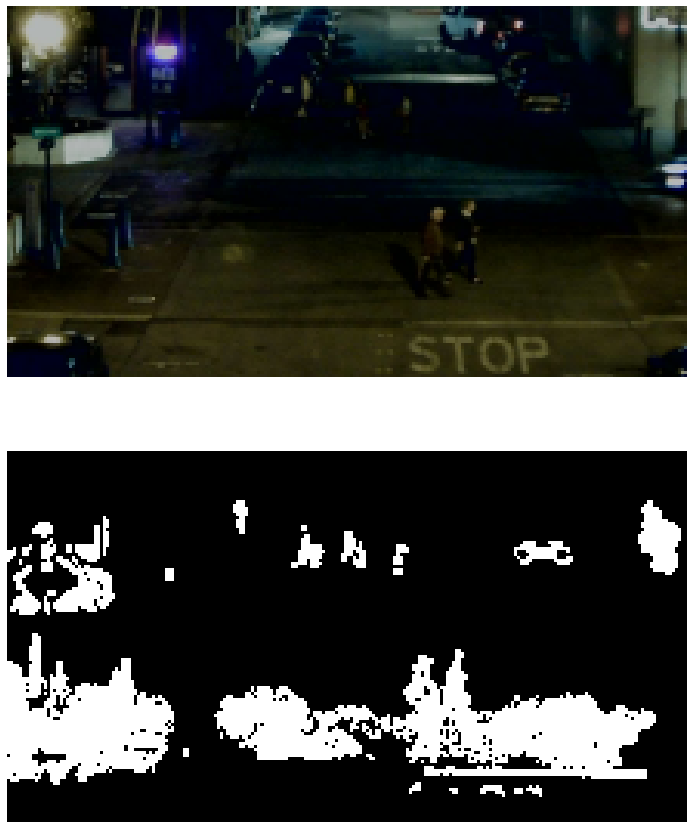

In [22]:
    _rgb = cv2.resize(rgb,None,fx=120/212,fy=120/212)
    _rgb = _rgb.astype('float32')/np.max(rgb)
f, axs = plt.subplots(2,1,figsize=(15,15))

axs[0].imshow(_rgb[:,100:])
axs[0].axis('off')
axs[1].imshow(_t[:,100:],cmap='gray')
axs[1].axis('off')

In [23]:
thresholded_ampl = thresholded_ampl[:,100:]
_thresholded_ampl = _thresholded_ampl[:,100:]
_rgb = _rgb[:,100:]

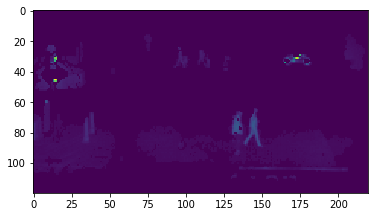

In [24]:
plt.imshow(thresholded_ampl)

In [25]:
_ergbHE = rgbEqualizeHistogram(_rgb)

In [26]:
_hsv = cv2.cvtColor(_rgb,cv2.COLOR_RGB2HSV)
_h,_s,_v = cv2.split(_hsv)
#_value = np.log(_value+0.000001)

alpha = 1.25
beta = 0.1
_cv = _v*alpha+beta
_ehsv = cv2.merge((_h,_s,_cv))
_ergbCB = cv2.cvtColor(_ehsv,cv2.COLOR_HSV2RGB)
_ergbCB[_ergbCB>1] = 1
_ergbCB[_ergbCB<0] = 0
_ergbHECB = rgbEqualizeHistogram(_ergbCB)

In [27]:
alpha = 2.25
beta = 0.1
_hsv = cv2.cvtColor(_rgb,cv2.COLOR_RGB2HSV)
_h,_s,_v = cv2.split(_hsv)
_cv = _v.copy()
#_cv[thresholded_ampl==0] = _v[thresholded_ampl==0]*alpha
_cv[thresholded_ampl>0] = _v[thresholded_ampl>0]*alpha+beta
_ehsv = cv2.merge((_h,_s,_cv))
_ergbCBD = cv2.cvtColor(_ehsv,cv2.COLOR_HSV2RGB)
_ergbCBD[_ergbCBD>1] = 1
_ergbCBD[_ergbCBD<0] = 0
_ergbHECBD = rgbEqualizeHistogram(_ergbCBD)

In [28]:
_hsv = cv2.cvtColor(_rgb,cv2.COLOR_RGB2HSV)
_h,_s,_v = cv2.split(_hsv)
_cv = _v.copy()
_cv = Stransform2(_v,delta2=1.0,m=_thresholded_ampl,n=3)
_ehsv = cv2.merge((_h,_s,_cv))
_ergbCBDS = cv2.cvtColor(_ehsv,cv2.COLOR_HSV2RGB)
_ergbCBDS[_ergbCBDS>1] = 1
_ergbCBDS[_ergbCBDS<0] = 0

(array([], dtype=int64), array([], dtype=int64))


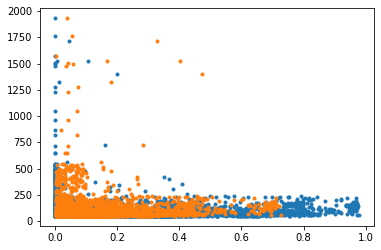

In [29]:
plt.plot(_cv[thresholded_ampl>0],thresholded_ampl[thresholded_ampl>0],'.')
plt.plot(_v[thresholded_ampl>0],thresholded_ampl[thresholded_ampl>0],'.')

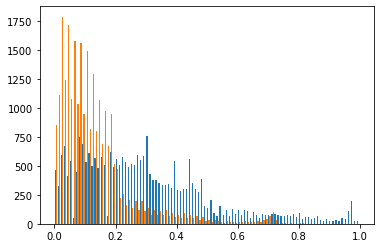

In [30]:
_=plt.hist(np.vstack((_cv.reshape(-1),_v.reshape(-1))).transpose(),100)

(-0.5, 219.5, 119.5, -0.5)

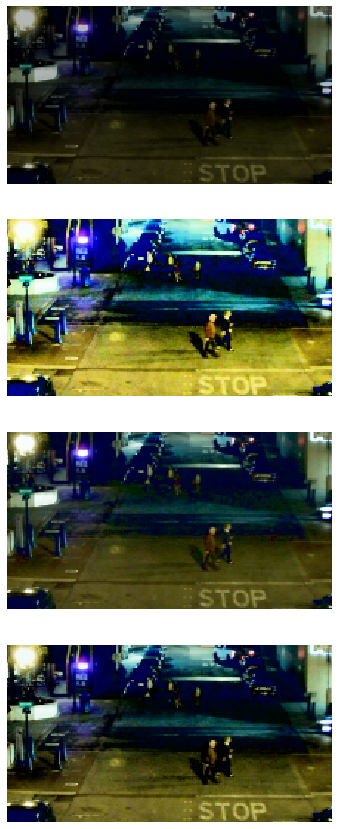

In [31]:
f, axs = plt.subplots(4,1,figsize=(15,15))
axs[0].imshow((_rgb))
axs[0].axis('off')
axs[1].imshow(_ergbHE)
axs[1].axis('off')
axs[2].imshow(_ergbCB)
axs[2].axis('off')
# axs[3].imshow(_ergbCBD)
# axs[3].axis('off')
axs[3].imshow(_ergbCBDS)
axs[3].axis('off')
#axs[5].imshow(_ergbCBDF)
#axs[5].axis('off')
# axs[5].imshow(_ergbCBDT)
# axs[5].axis('off')

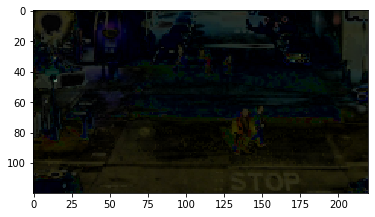

In [32]:
plt.imshow(np.abs(_ergbCB-_ergbCBDS)*1)

In [33]:
hsv = cv2.cvtColor(_rgb,cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(hsv)
hsveq = cv2.cvtColor(_ergbHE,cv2.COLOR_RGB2HSV)
h,seq,veq = cv2.split(hsveq)

In [34]:
sys.path.append('/Users/rsingh/Packages/homomorphic-filter/')

In [35]:
from homofilt import HomomorphicFilter

In [36]:
homo_filter = HomomorphicFilter(a=0.8, b = 1.2)

In [38]:
hsv = cv2.cvtColor(_rgb,cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(hsv)
#fh = homo_filter.filter(I=h,filter_params=[30,2])
#fs = homo_filter.filter(I=s,filter_params=[30,2])
fv = homo_filter.filter(I=v,filter_params=[30,2])
fv = fv.astype('float32')
hsv = cv2.merge((h,s,fv)).astype('float32')
rgbHF = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
rgbHF[rgbHF<0] = 0
rgbHF[rgbHF>1] = 1
fv2 = homo_filter.filter(I=v,filter_params=[30,2],D=_thresholded_ampl)
fv2 = fv2.astype('float32')
hsv = cv2.merge((h,s,fv2)).astype('float32')
rgbHFD = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
rgbHFD[rgbHFD<0] = 0
rgbHFD[rgbHFD>1] = 1

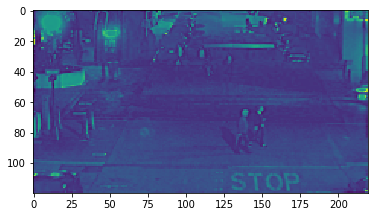

In [39]:
plt.imshow(fv)

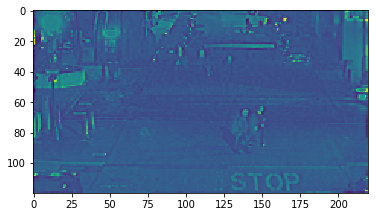

In [40]:
plt.imshow(fv2)

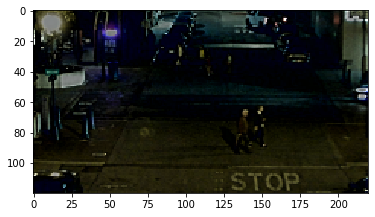

In [41]:
plt.imshow(rgbHF)

In [43]:
np.random.randint(0,500)

358

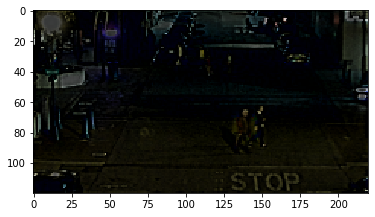

In [42]:
plt.imshow(rgbHFD)

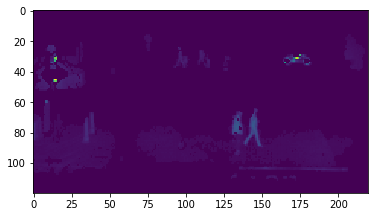

In [47]:
plt.imshow(thresholded_ampl)

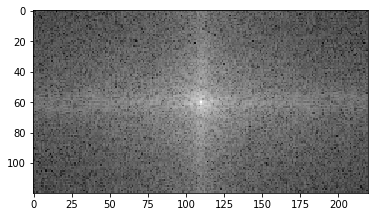

In [263]:
f = (np.fft.fft2(v))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
magnitude_spectrum -= np.min(magnitude_spectrum)
magnitude_spectrum /= np.max(magnitude_spectrum)
plt.imshow(magnitude_spectrum,cmap='gray')

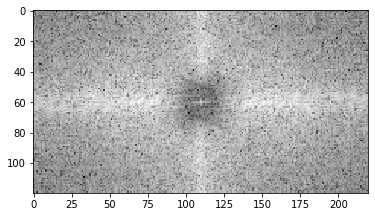

In [264]:
f = (np.fft.fft2(fv))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
magnitude_spectrum -= np.min(magnitude_spectrum)
magnitude_spectrum /= np.max(magnitude_spectrum)
plt.imshow(magnitude_spectrum,cmap='gray')

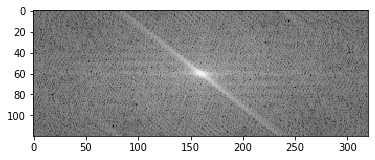

In [228]:
f = (np.fft.fft2(_thresholded_ampl))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
magnitude_spectrum -= np.min(magnitude_spectrum)
magnitude_spectrum /= np.max(magnitude_spectrum)
plt.imshow(magnitude_spectrum,cmap='gray')

In [207]:
shad = plt.imread(dir_path+'kitti/2d/intrinsic/oyla_188-s.png')
refl = plt.imread(dir_path+'kitti/2d/intrinsic/oyla_188-r.png')

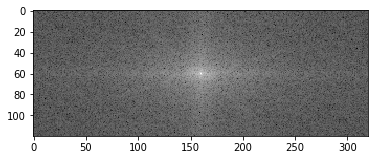

In [225]:
f = (np.fft.fft2(np.log(shad)))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
magnitude_spectrum -= np.min(magnitude_spectrum)
magnitude_spectrum /= np.max(magnitude_spectrum)
plt.imshow(magnitude_spectrum,cmap='gray')

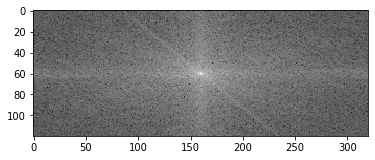

In [226]:
f = (np.fft.fft2(np.log(np.mean(refl,axis=2))))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
magnitude_spectrum -= np.min(magnitude_spectrum)
magnitude_spectrum /= np.max(magnitude_spectrum)
plt.imshow(magnitude_spectrum,cmap='gray')

In [65]:
rgb = plt.imread('/Users/rsingh/Downloads/carpet_00_flash.jpg')

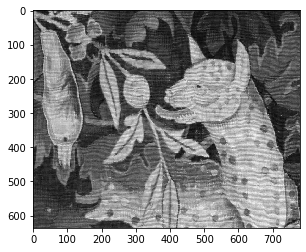

In [66]:
plt.imshow(rgb[:,:,0],cmap='gray')

In [67]:
_rgb = rgb.astype('float32')/255
_rgbEq = rgbEqualizeHistogram(_rgb)

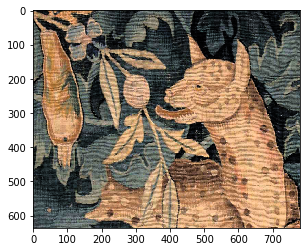

In [68]:
plt.imshow(_rgbEq)

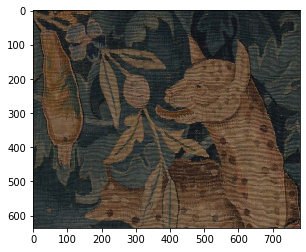

In [69]:
plt.imshow(_rgb)

In [70]:
_hsv = cv2.cvtColor(_rgb,cv2.COLOR_RGB2HSV)

In [71]:
_hsvEq = cv2.cvtColor(_rgbEq,cv2.COLOR_RGB2HSV)

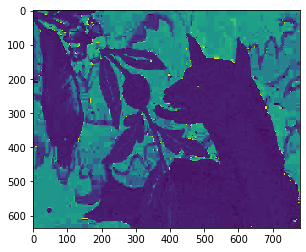

In [72]:
plt.imshow(_hsv[:,:,0])

2.315404
0.011640986
0.22949708


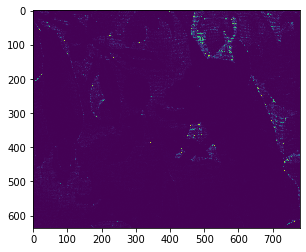

In [79]:
plt.imshow(np.abs(_hsvEq[:,:,1]-_hsv[:,:,1]))
print(np.mean(np.abs(_hsvEq[:,:,0]-_hsv[:,:,0])))
print(np.mean(np.abs(_hsvEq[:,:,1]-_hsv[:,:,1])))
print(np.mean(np.abs(_hsvEq[:,:,2]-_hsv[:,:,2])))

In [121]:
_l = np.sum(_rgb,axis=2)

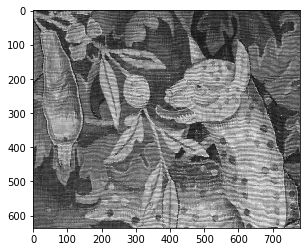

In [122]:
plt.imshow(_l,cmap='gray')

In [159]:
l = (_l/3*255).astype('uint8')
fl = cv2.equalizeHist(l)
_fl = l.astype('float32')/255.0

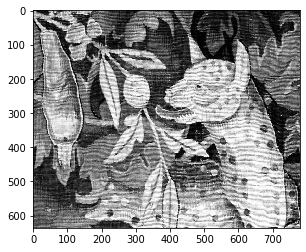

In [161]:
plt.imshow(fl,cmap='gray')

In [124]:
def Stransform(x,delta1=0,delta2=1,n=2,m=0.5):
    y = np.zeros_like(x)
    
    ind = np.where((x<=m)&(x>=delta1))
    y[ind] = delta1+(m-delta1)*np.power((x[ind]-delta1)/(m-delta1),n)
    ind = np.where((x>m)&(x<=delta2))
    y[ind] = delta2-(delta2-m)*np.power((delta2-x[ind])/(delta2-m),n)
    return y

In [274]:
_sl = Stransform(_l,delta1 =0, delta2=np.max(_l),m=np.max(_l)/1.2)

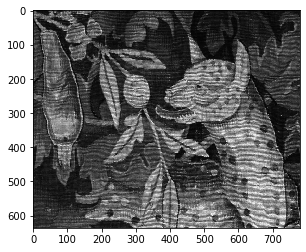

In [275]:
plt.imshow(_sl,cmap='gray')

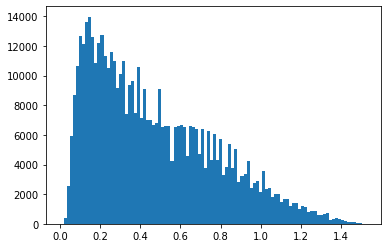

In [276]:
_=plt.hist(_sl.reshape(-1),100)

In [213]:
np.where(_sl/_l>1)[0].shape

(217654,)

In [214]:
np.where(_sl/_l<=1)[0].shape

(278426,)

In [216]:
_ergb = (_sl/_l)[:,:,np.newaxis]*_rgb

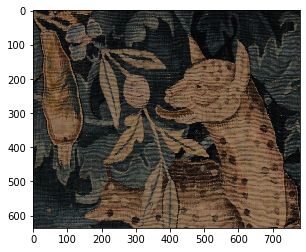

In [217]:
plt.imshow(_ergb)

In [262]:
def huepreserve(rgb,sl,l):
    alpha = sl/l
    #alpha = alpha[:,:,np.newaxis]
    ergb = np.zeros_like(rgb)
    for i in range(3):
        ergb[alpha<=1,i] = alpha[alpha<=1]*rgb[alpha<=1,i]
    cmy = 1-rgb
    beta = (3-sl)/(3-l)
    #beta = beta[:,:,np.newaxis]
    for i in range(3):
        ergb[alpha>1,i] = 1-beta[alpha>1]*cmy[alpha>1,i]
    return ergb

In [263]:
_hergb = huepreserve(_rgb,_sl,_l)

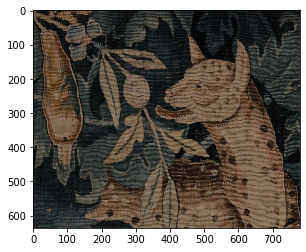

In [264]:
plt.imshow(_hergb)

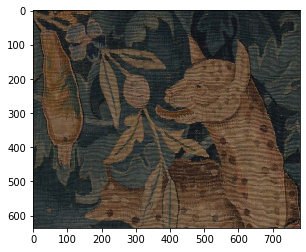

In [265]:
plt.imshow(_rgb)

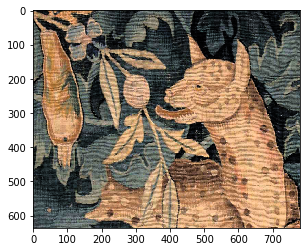

In [266]:
plt.imshow(_rgbEq)

In [267]:
_hehsv = cv2.cvtColor(_hergb,cv2.COLOR_RGB2HSV)


5.0033716e-05
0.0231691
0.045241393


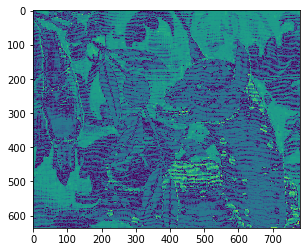

In [270]:
plt.imshow(np.abs(_hehsv[:,:,2]-_hsv[:,:,2]))
print(np.mean(np.abs(_hehsv[:,:,0]-_hsv[:,:,0])))
print(np.mean(np.abs(_hehsv[:,:,1]-_hsv[:,:,1])))
print(np.mean(np.abs(_hehsv[:,:,2]-_hsv[:,:,2])))

In [285]:
_hsv = cv2.cvtColor(_rgb,cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(_hsv)

In [309]:
sv = Stransform(v,delta2=np.max(v),m=0.01)

(array([11417.,  9914.,  4564.,  3515.,  2302.,  1866.,  2796.,   889.,
          470.,   667.]),
 array([0.        , 0.08486056, 0.16972111, 0.25458166, 0.33944222,
        0.4243028 , 0.5091633 , 0.5940239 , 0.67888445, 0.763745  ,
        0.8486056 ], dtype=float32),
 <a list of 10 Patch objects>)

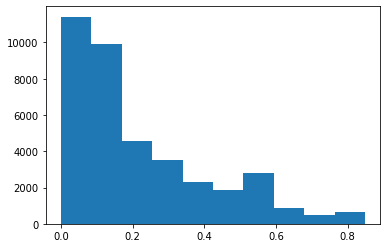

In [310]:
plt.hist(sv.reshape(-1))

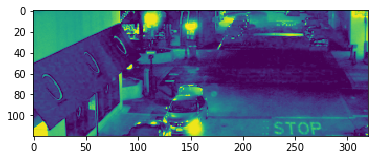

In [311]:
plt.imshow(sv)

In [326]:
sv = Stransform2(v,delta2=np.max(v),m=_thresholded_ampl)

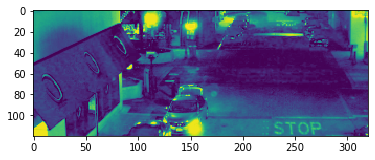

In [327]:
plt.imshow(sv)

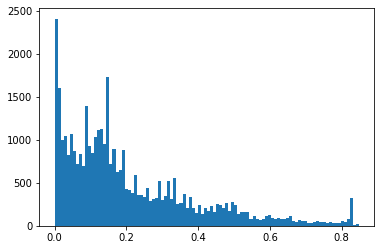

In [330]:
_=plt.hist(sv.reshape(-1),100)

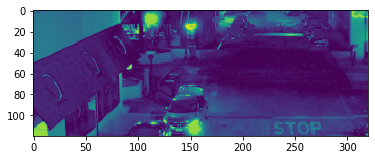

In [331]:
plt.imshow(v)

In [210]:
a = cv2.imread('/Users/rsingh/Downloads/sin1.png',0)
print(a)

[[255 254 252 ... 249 252 254]
 [255 254 252 ... 249 252 254]
 [255 254 252 ... 249 252 254]
 ...
 [255 254 252 ... 249 252 254]
 [255 254 252 ... 249 252 254]
 [255 254 252 ... 249 252 254]]


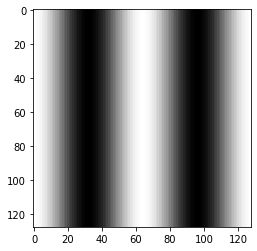

In [211]:
plt.imshow(a,cmap='gray')

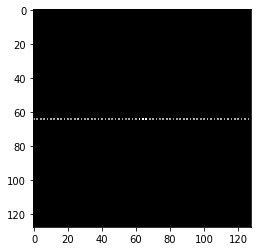

In [214]:
f = (np.fft.fft2(a))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift)+0.00001)
magnitude_spectrum -= np.min(magnitude_spectrum)
magnitude_spectrum /= np.max(magnitude_spectrum)
plt.imshow(magnitude_spectrum,cmap='gray')